Data Cleaning and Exploration

In [103]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

In [ ]:
sns.set_palette("viridis")

df = pd.read_csv("../data/listings.csv")
df.shape

(83850, 17)

We have Airbnb London dataset  which includes longitude and latitude which allows implement it in streamlit map

In [59]:
df.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,65,1,16,2019-06-10,0.15,3,347
1,1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,85,2019-05-05,0.73,1,203
2,2,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52098,-0.14002,Entire home/apt,300,3,41,2019-06-19,0.41,14,269
3,3,24328,Battersea bedroom & office w parking shared ga...,41759,Joe,NaN,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,93,2019-06-08,0.88,1,329
4,4,25023,All-comforts 2-bed flat near Wimbledon tennis,102813,Amanda,NaN,Wandsworth,51.44687,-0.21874,Entire home/apt,65,4,28,2019-06-22,0.69,1,2


In [60]:
df = df.drop(columns=[
    "index",
    "id",
    "name",
    "host_name",
    "last_review",
    "neighbourhood_group"
])

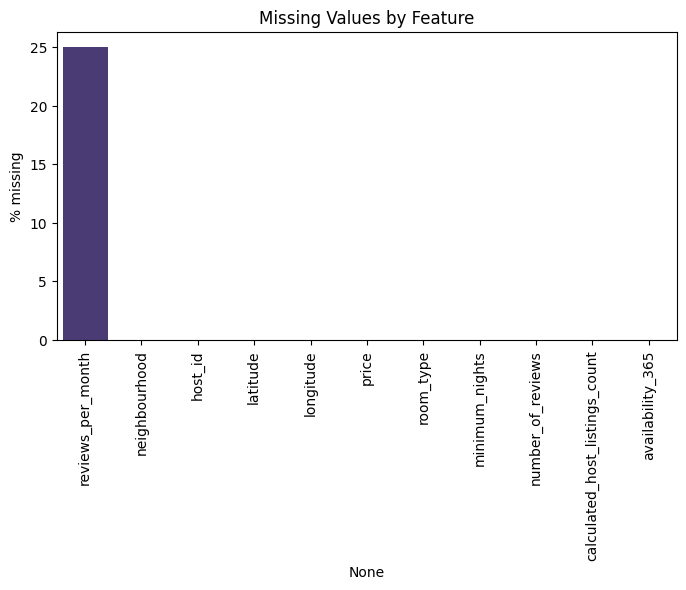

In [61]:
miss = df.isna().mean().sort_values(ascending=False) * 100
plt.figure(figsize=(8,4))
sns.barplot(x=miss.index, y=miss.values)
plt.xticks(rotation=90)
plt.ylabel("% missing")
plt.title("Missing Values by Feature")
plt.show()

In [62]:
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83850 entries, 0 to 83849
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         83850 non-null  int64  
 1   neighbourhood                   83850 non-null  object 
 2   latitude                        83850 non-null  float64
 3   longitude                       83850 non-null  float64
 4   room_type                       83850 non-null  object 
 5   price                           83850 non-null  int64  
 6   minimum_nights                  83850 non-null  int64  
 7   number_of_reviews               83850 non-null  int64  
 8   reviews_per_month               62827 non-null  float64
 9   calculated_host_listings_count  83850 non-null  int64  
 10  availability_365                83850 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 7.0+ MB


np.int64(0)

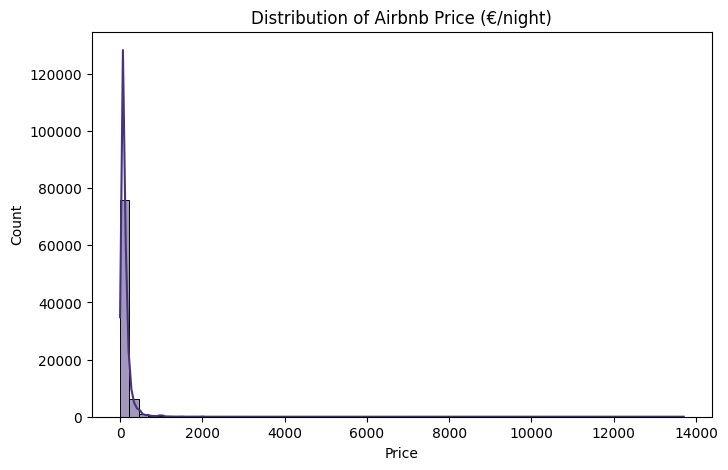

In [63]:
plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=60, kde=True)
plt.title("Distribution of Airbnb Price (€/night)")
plt.xlabel("Price")
plt.show()

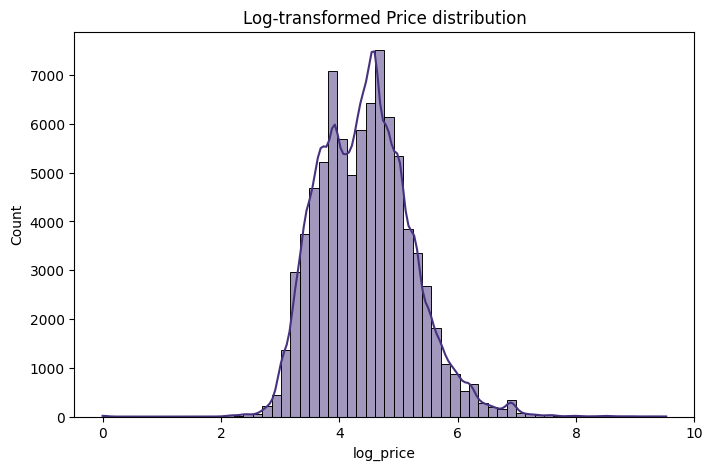

In [64]:
df["log_price"] = np.log1p(df["price"])
plt.figure(figsize=(8,5))
sns.histplot(df["log_price"], bins=60, kde=True)
plt.title("Log-transformed Price distribution")
plt.show()

In [65]:
%pip install pydeck

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pydeck as pdk

sample = df.sample(5000)  

layer = pdk.Layer(
    "ScatterplotLayer",
    data=sample,
    get_position=["longitude", "latitude"],
    get_radius=50,
    get_fill_color="[price/10, 100, 200]",
    pickable=True,
)

view = pdk.ViewState(
    latitude=51.51,
    longitude=-0.12,
    zoom=10,
    pitch=0,
)

r = pdk.Deck(layers=[layer], initial_view_state=view)
r.to_html("pydeck_map.html", open_browser=True)

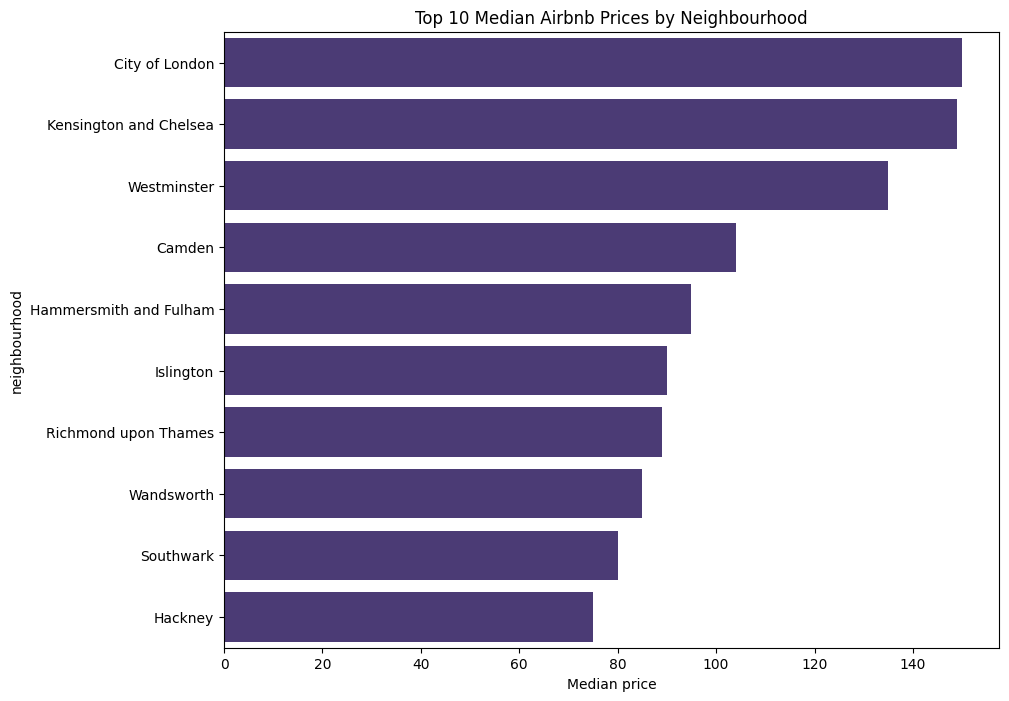

In [67]:
plt.figure(figsize=(10,8))
top10 = df.groupby("neighbourhood")["price"].median().nlargest(10)
sns.barplot(x=top10.values, y=top10.index)
plt.title("Top 10 Median Airbnb Prices by Neighbourhood")
plt.xlabel("Median price")
plt.show()

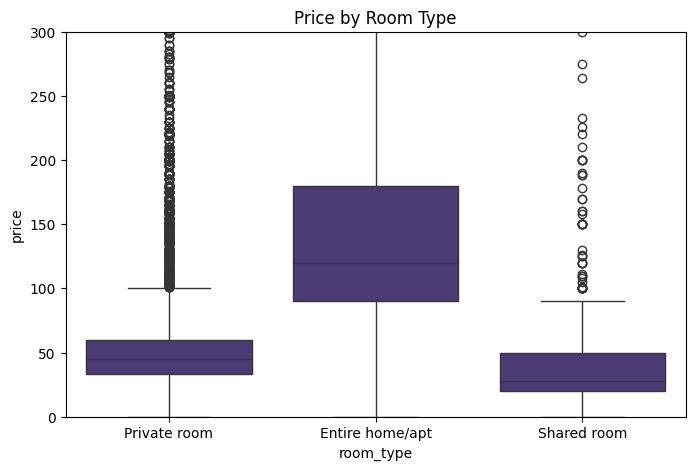

In [68]:
plt.figure(figsize=(8,5))
sns.boxplot(x="room_type", y="price", data=df)
plt.ylim(0, 300)
plt.title("Price by Room Type")
plt.show()

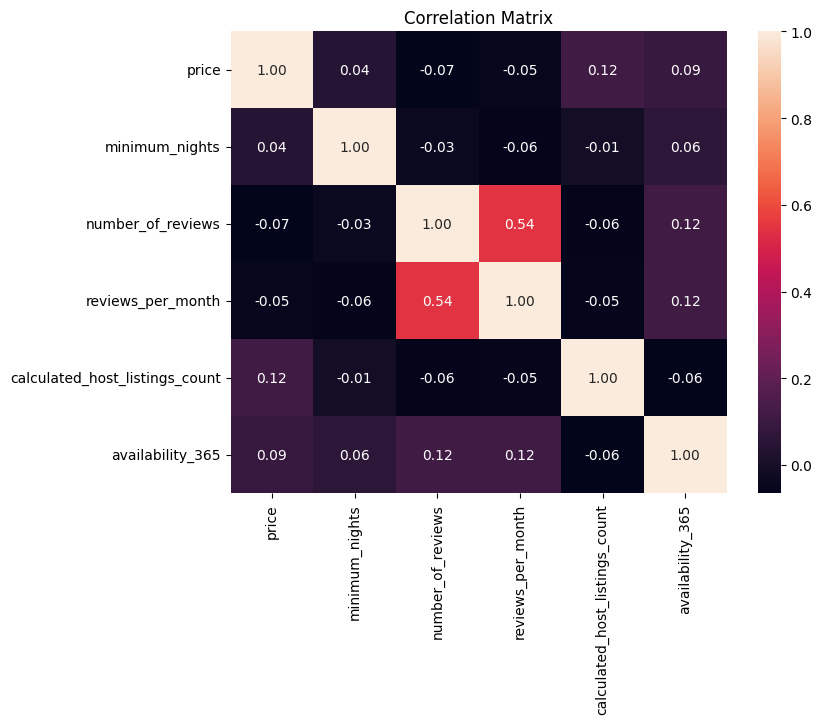

In [69]:
num_cols = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", 
            "calculated_host_listings_count", "availability_365"]
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [70]:
print(df["room_type"].value_counts())
print(df["neighbourhood"].nunique(), "distinct neighbourhoods")

room_type
Entire home/apt    47142
Private room       35972
Shared room          736
Name: count, dtype: int64
33 distinct neighbourhoods


In [71]:
df["price"].describe()

count    83850.000000
mean       121.656303
std        224.900151
min          0.000000
25%         45.000000
50%         81.000000
75%        140.000000
max      13700.000000
Name: price, dtype: float64

In [72]:
df = df[df["price"] > 0]

low, high = df["price"].quantile([0.01, 0.99])
df = df[(df["price"] >= low) & (df["price"] <= high)]

In [73]:
df.isna().mean().sort_values(ascending=False)

reviews_per_month                 0.246481
host_id                           0.000000
latitude                          0.000000
neighbourhood                     0.000000
longitude                         0.000000
room_type                         0.000000
minimum_nights                    0.000000
price                             0.000000
number_of_reviews                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
log_price                         0.000000
dtype: float64

In [74]:
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

In [75]:
df[["latitude", "longitude"]].describe()

,latitude,longitude
count,82189.000000,82189.000000
mean,51.509460,-0.128567
std,0.046201,0.091960
min,51.292720,-0.501300
25%,51.485140,-0.188550
50%,51.514020,-0.125640
75%,51.537370,-0.070470
max,51.686570,0.296570


In [76]:
df["room_type"].value_counts()
df["neighbourhood"].nunique()

33

In [77]:
df["log_price"] = np.log1p(df["price"])

In [78]:
df = df[df["minimum_nights"] <= 365]

In [79]:
FEATURES = [
    "latitude",
    "longitude",
    "room_type",
    "neighbourhood",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count"
]

TARGET = "log_price"

df_model = df[FEATURES + [TARGET]].copy()

In [80]:
df_model.to_csv("../data/processed.csv", index=False)

Prediction Model training and selection

In [91]:
df1 = pd.read_csv("../data/processed.csv") 
FEATURES = [
    "latitude","longitude","room_type","neighbourhood",
    "minimum_nights","number_of_reviews","reviews_per_month",
    "calculated_host_listings_count","availability_365"
]

In [92]:
TARGET = "log_price" 

In [93]:
df = df.dropna(subset=FEATURES + [TARGET]).copy()

X = df[FEATURES]
y = df[TARGET]

In [94]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [95]:
NUM_COLS = [
    "latitude","longitude","minimum_nights","number_of_reviews",
    "reviews_per_month","calculated_host_listings_count","availability_365"
]
CAT_COLS = ["room_type","neighbourhood"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), NUM_COLS),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), CAT_COLS),
    ]
)

In [99]:
def eval_real_price(y_true_log, y_pred_log):
    y_true = np.expm1(np.asarray(y_true_log))
    y_pred = np.expm1(np.asarray(y_pred_log))
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

results = []

In [ ]:
# Ridge (baseline) 
ridge = Pipeline([("prep", preprocess), ("model", Ridge(alpha=1.0))])
ridge.fit(X_train, y_train)
pred = ridge.predict(X_val)
mae, rmse = eval_real_price(y_val, pred)
results.append(("Ridge (baseline)", mae, rmse))

# RandomForest 
rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])
rf.fit(X_train, y_train)
pred = rf.predict(X_val)
mae, rmse = eval_real_price(y_val, pred)
results.append(("RandomForest", mae, rmse))

# CatBoost
try:
    from catboost import CatBoostRegressor
    cat = CatBoostRegressor(
        iterations=800,
        learning_rate=0.08,
        depth=8,
        loss_function="MAE",
        random_seed=42,
        verbose=False,
    )
    cat.fit(X_train, y_train, cat_features=CAT_COLS)
    pred = cat.predict(X_val)
    mae, rmse = eval_real_price(y_val, pred)
    results.append(("CatBoost", mae, rmse))
except Exception:
    results.append(("CatBoost (install: pip install catboost)", np.nan, np.nan))

pd.DataFrame(results, columns=["Model", "MAE (£)", "RMSE (£)"]).sort_values("MAE (£)").reset_index(drop=True)

,Model,MAE (£),RMSE (£)
0,RandomForest,36.591403,66.274198
1,RandomForest,36.591403,66.274198
2,Ridge (baseline),42.632006,78.070644
3,Ridge (baseline),42.632006,78.070644
4,CatBoost (install: pip install catboost),NaN,NaN
5,CatBoost (install: pip install catboost),NaN,NaN
